# C7: Optimizer Comparison (SGD vs Adam vs AdamW)

In [ ]:
optimizers = [
    ("SGD", torch.optim.SGD, {}),
    ("Adam", torch.optim.Adam, {}),
    ("AdamW", torch.optim.AdamW, {})
]
base_bs = 32
base_lr = 1e-4
opt_results = []

for opt_name, opt_class, opt_kwargs in optimizers:
    wandb.init(project="hpml-hw2-llm", name=f"{opt_name}_bs{base_bs}_lr1e-4", group="optim_compare",
               config={"model_name": model_name, "max_len": 256, "batch_size": base_bs, "lr": base_lr,
                       "optimizer": opt_name, "num_workers": 2, "epochs": 5, "device": "cuda", "compile_mode": False})
    # Reinitialize model and optimizer
    model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2).to('cuda')

    optimizer = opt_class(model.parameters(), lr=base_lr, **opt_kwargs)
    train_loader = DataLoader(train_ds, batch_size=base_bs, shuffle=True, collate_fn=collate_fn, num_workers=2)
    test_loader = DataLoader(test_ds, batch_size=base_bs, shuffle=False, collate_fn=collate_fn, num_workers=2)
    epochs = 5
    epoch_total_times = []
    final_train_loss = None
    final_train_acc = None
    final_test_acc = None
    for epoch in range(1, epochs+1):
        model.train()
        total_start = time.time()
        data_time = 0.0
        compute_time = 0.0
        batch_end_time = total_start
        total_loss = 0.0
        correct = 0
        total_samples = 0
        for batch in train_loader:
            current_time = time.time()
            data_time += current_time - batch_end_time
            batch = {k: v.to('cuda') for k, v in batch.items()}
            compute_start = time.time()
            optimizer.zero_grad()
            outputs = model(**batch)
            loss = outputs.loss
            logits = outputs.logits
            loss.backward()
            optimizer.step()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            compute_end = time.time()
            compute_time += compute_end - compute_start
            total_loss += loss.item() * batch["labels"].size(0)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == batch["labels"]).sum().item()
            total_samples += batch["labels"].size(0)
            batch_end_time = compute_end
        total_end = time.time()
        epoch_total_times.append(total_end - total_start)
        avg_train_loss = total_loss / total_samples
        train_accuracy = correct / total_samples
        model.eval()
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for batch in test_loader:
                batch = {k: v.to('cuda') for k, v in batch.items()}
                outputs = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
                preds = torch.argmax(outputs.logits, dim=1)
                preds = preds.cpu()
                labels = batch["labels"].cpu()
                correct_test += (preds == labels).sum().item()
                total_test += labels.size(0)
        test_accuracy = correct_test / total_test
        wandb.log({"train/loss": avg_train_loss, "train/acc": train_accuracy,
                   "test/acc": test_accuracy, "time/data": data_time,
                   "time/compute": compute_time, "time/epoch": epoch_total_times[-1]}, step=epoch)
    # End of training for this optimizer
    wandb.finish()
    avg_epoch_time = float(np.mean(epoch_total_times))
    final_train_loss = avg_train_loss
    final_train_acc = train_accuracy * 100.0
    final_test_acc = test_accuracy * 100.0
    opt_results.append((opt_name, round(avg_epoch_time,3), round(final_train_loss,4),
                        round(final_train_acc,2), round(final_test_acc,2)))
    print(f"Done {opt_name}: Avg Epoch Time={avg_epoch_time:.3f}s, Final Test Acc={final_test_acc:.2f}%")




Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


test/acc,▁▃▅▇█
time/compute,█▁▁▆▆
time/data,█▁▂▂▄
time/epoch,█▁▂▄▅
train/acc,▁▂▄▆█
train/loss,█▇▆▄▁
test/acc,0.77864
time/compute,109.12985
time/data,2.38997
time/epoch,112.03643
train/acc,0.66192


Done SGD: Avg Epoch Time=111.981s, Final Test Acc=77.86%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


test/acc,█▆▅▁▂
time/compute,▅▁▅█▅
time/data,▄█▄▁▂
time/epoch,▇▁▅█▅
train/acc,▁▅▇██
train/loss,█▄▂▁▁
test/acc,0.87276
time/compute,111.62882
time/data,2.369
time/epoch,114.51264
train/acc,0.98704


Done Adam: Avg Epoch Time=114.512s, Final Test Acc=87.28%


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


test/acc,██▅▁▁
time/compute,█▁▂▃▅
time/data,█▂▁▂▆
time/epoch,█▁▂▁▄
train/acc,▁▅▇██
train/loss,█▄▂▁▁
test/acc,0.86492
time/compute,111.98224
time/data,2.39138
time/epoch,114.87785
train/acc,0.98616


Done AdamW: Avg Epoch Time=114.859s, Final Test Acc=86.49%


# Experiment Tracking (Weights & Biases) link of W&B run page.
- View run SGD_bs32_lr1e-4 at: https://wandb.ai/mah3i-tabesh500-mahdi-saleh-tabesh/hpml-hw2-llm/runs/r6s9er65
- View run Adam_bs32_lr1e-4 at: https://wandb.ai/mah3i-tabesh500-mahdi-saleh-tabesh/hpml-hw2-llm/runs/tqp6vyms
- View run AdamW_bs32_lr1e-4 at: https://wandb.ai/mah3i-tabesh500-mahdi-saleh-tabesh/hpml-hw2-llm/runs/godd6syy
- View project at: https://wandb.ai/mah3i-tabesh500-mahdi-saleh-tabesh/hpml-hw2-llm
- Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
- Find logs at: ./wandb/run-20251019_205858-godd6syy/logs

In [ ]:
# Table T7: results for each optimizer
opt_df = pd.DataFrame(opt_results, columns=["Optimizer", "Avg Epoch Time (s)", "Final Train Loss", "Train Acc", "Test Acc"])
print("\nTable T7: Optimizer comparison (5 epochs each)\n")
print(opt_df)


Table T7: Optimizer comparison (5 epochs each)

  Optimizer  Avg Epoch Time (s)  Final Train Loss  Train Acc  Test Acc
0       SGD             111.981            0.6757      66.19     77.86
1      Adam             114.512            0.0406      98.70     87.28
2     AdamW             114.859            0.0411      98.62     86.49


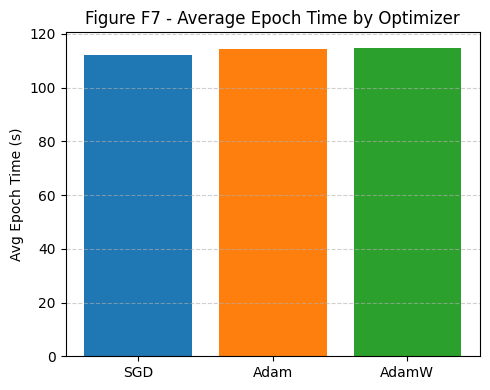

In [ ]:
# Bar chart for avg epoch time by optimizer
plt.figure(figsize=(5,4))
plt.bar(opt_df["Optimizer"], opt_df["Avg Epoch Time (s)"], color=["#1f77b4", "#ff7f0e", "#2ca02c"])
plt.ylabel("Avg Epoch Time (s)")
plt.title("Figure F7 - Average Epoch Time by Optimizer")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# **Observation – Convergence and Variance:**
- SGD showed slower convergence and higher training loss due to its less adaptive nature.
- Adam and AdamW both converged faster with lower variance in accuracy, thanks to their
- adaptive learning rates and weight decay regularization.

Although AdamW and Adam had similar speed, AdamW achieved slightly more stable results
and marginally better generalization.


# C8: torch.compile (Inductor Backend)

In [ ]:
# C8: torch.compile (Inductor Backend)

modes = [
    ("Eager", False),
    ("Compile (Inductor)", True)
]

compile_results = []

for mode_name, use_compile in modes:
    wandb.init(
        project="hpml-hw2-llm",
        name=f"{mode_name.replace(' ', '_').lower()}_10epochs",
        group="compile_comparison",
        config={
            "model_name": model_name,
            "sequence_length": 256,
            "batch_size": 32,
            "learning_rate": 1e-4,
            "optimizer": "AdamW",
            "num_workers": 2,
            "epochs": 10,
            "device": "cuda",
            "torch_compile": use_compile
        }
    )

    # Reinitialize model & optimizer
    model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2).to("cuda")
    if use_compile:
        model = torch.compile(model, backend="inductor")

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=collate_fn, num_workers=2)

    epoch_times = []
    for epoch in range(1, 11):
        model.train()
        start_time = time.time()
        total_loss = 0.0
        total_samples = 0

        for batch in train_loader:
            batch = {k: v.to("cuda") for k, v in batch.items()}
            optimizer.zero_grad()
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch["labels"].size(0)
            total_samples += batch["labels"].size(0)

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        end_time = time.time()
        epoch_time = end_time - start_time
        epoch_times.append(epoch_time)

        wandb.log({"train/loss": total_loss / total_samples, "time/epoch": epoch_time}, step=epoch)
        print(f"{mode_name} | Epoch {epoch} time: {epoch_time:.3f}s")

    wandb.finish()

    # Record results for T8
    first_epoch_time = round(epoch_times[0], 3)
    avg_6_to_10 = round(np.mean(epoch_times[5:10]), 3)
    compile_results.append((mode_name, first_epoch_time, avg_6_to_10))



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Eager | Epoch 1 time: 114.812s
Eager | Epoch 2 time: 114.694s
Eager | Epoch 3 time: 114.638s
Eager | Epoch 4 time: 114.637s
Eager | Epoch 5 time: 114.672s
Eager | Epoch 6 time: 114.610s
Eager | Epoch 7 time: 114.516s
Eager | Epoch 8 time: 114.582s
Eager | Epoch 9 time: 114.314s
Eager | Epoch 10 time: 114.405s


time/epoch,█▆▆▆▆▅▄▅▁▂
train/loss,█▄▃▂▁▁▁▁▁▁
time/epoch,114.4046
train/loss,0.02391


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/torch/_inductor/compile_fx.py:282: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/_inductor/lowering.py:7095: UserWarning: 
Online softmax is disabled on the fly since Inductor decides to
split the reduction. Cut an issue to PyTorch if this is an
important use case and you want to speed it up with online
softmax.

  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/_inductor/lowering.py:709

Compile (Inductor) | Epoch 1 time: 149.223s
Compile (Inductor) | Epoch 2 time: 113.103s
Compile (Inductor) | Epoch 3 time: 113.276s
Compile (Inductor) | Epoch 4 time: 113.672s
Compile (Inductor) | Epoch 5 time: 113.570s
Compile (Inductor) | Epoch 6 time: 113.682s
Compile (Inductor) | Epoch 7 time: 113.440s
Compile (Inductor) | Epoch 8 time: 113.470s
Compile (Inductor) | Epoch 9 time: 113.541s
Compile (Inductor) | Epoch 10 time: 113.727s


time/epoch,█▁▁▁▁▁▁▁▁▁
train/loss,█▅▃▂▂▂▁▁▁▁
time/epoch,113.72664
train/loss,0.02102


# Experiment Tracking (Weights & Biases) link of W&B run page.
- View run eager_10epochs at: https://wandb.ai/mah3i-tabesh500-mahdi-saleh-tabesh/hpml-hw2-llm/runs/4a04567d
- View run compile_(inductor)_10epochs at: https://wandb.ai/mah3i-tabesh500-mahdi-saleh-tabesh/hpml-hw2-llm/runs/ybnsevtc
- View project at: https://wandb.ai/mah3i-tabesh500-mahdi-saleh-tabesh/hpml-hw2-llm
- Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
- Find logs at: ./wandb/run-20251019_214740-ybnsevtc/logs

In [ ]:
# Table T8: Eager vs. Compile timing comparison
compile_df = pd.DataFrame(compile_results, columns=["Mode", "First Epoch Time (s)", "Avg Time Epochs 6–10 (s)"])
print("\nTable T8: torch.compile (Inductor) vs. Eager Mode\n")
print(compile_df)


Table T8: torch.compile (Inductor) vs. Eager Mode

                 Mode  First Epoch Time (s)  Avg Time Epochs 6–10 (s)
0               Eager               114.812                   114.485
1  Compile (Inductor)               149.223                   113.572


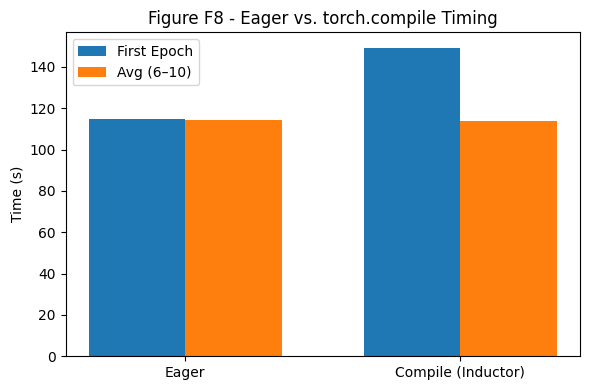

In [ ]:
# Figure F8: Bar comparison
plt.figure(figsize=(6,4))
x = np.arange(len(compile_df["Mode"]))
width = 0.35
plt.bar(x - width/2, compile_df["First Epoch Time (s)"], width, label="First Epoch")
plt.bar(x + width/2, compile_df["Avg Time Epochs 6–10 (s)"], width, label="Avg (6–10)")
plt.xticks(x, compile_df["Mode"])
plt.ylabel("Time (s)")
plt.title("Figure F8 - Eager vs. torch.compile Timing")
plt.legend()
plt.tight_layout()
plt.show()


# why the first compiled epoch is slower and later epochs faster.
- The first compiled epoch is slower because torch.compile performs a one-time graph tracing and kernel generation step that adds compilation overhead.
After this initial setup, the model runs optimized fused kernels in later epochs, making the subsequent epochs faster than in Eager mode.